In [2]:
import os
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
from datetime import datetime

# Get all tensorboard log directories
log_dirs = []
for root, dirs, files in os.walk('./autoruns'):
    for dir in dirs:
        if 'events.out.tfevents' in str(os.listdir(os.path.join(root, dir))):
            log_dirs.append(os.path.join(root, dir))

# Extract data from each log directory
all_data = []
for log_dir in log_dirs:
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get run name from directory
    run_name = os.path.basename(os.path.dirname(log_dir))
    
    # Extract rewards
    if 'Episode/rew_direction' in event_acc.Tags()['scalars']:
        rewards = event_acc.Scalars('Episode/rew_direction')
        
        # Convert to DataFrame
        df = pd.DataFrame([(r.wall_time, r.step, r.value) for r in rewards],
                         columns=['time', 'step', 'rew_direction'])
        
        # Calculate relative time in hours
        df['rel_time'] = (df['time'] - df['time'].min()) / 3600
        
        df['run'] = run_name
        all_data.append(df)
print(len(all_data))

65


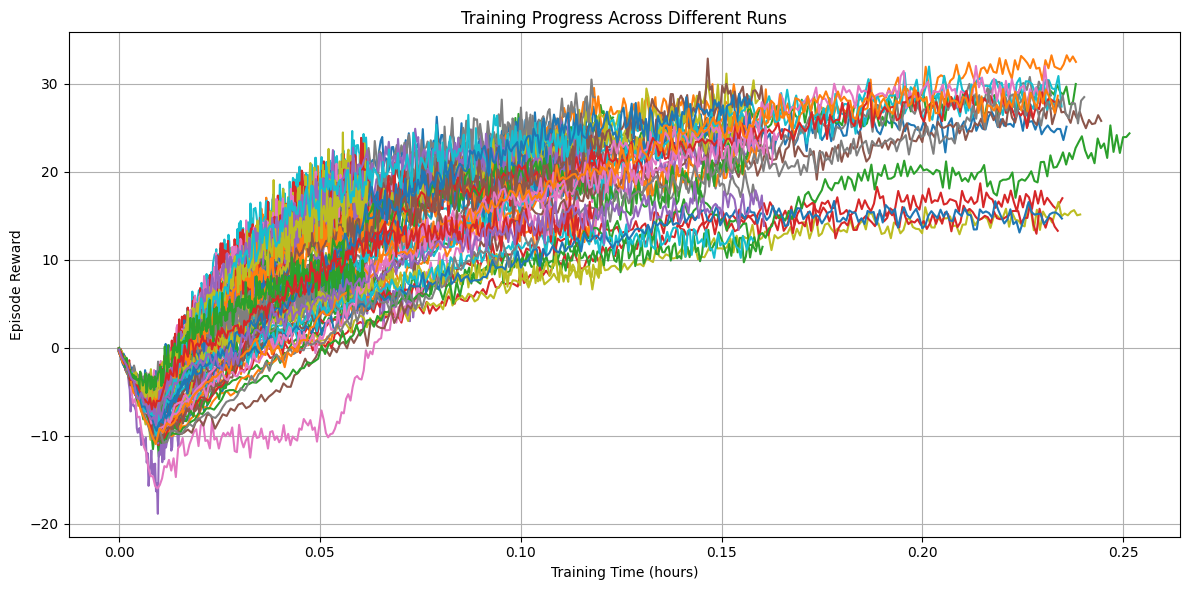

In [3]:

plt.figure(figsize=(12, 6))
for run in all_data:
    plt.plot(run['rel_time'], run['rew_direction'])

plt.xlabel('Training Time (hours)')
plt.ylabel('Episode Reward')
plt.title('Training Progress Across Different Runs')
plt.grid(True)
plt.tight_layout()
plt.show()


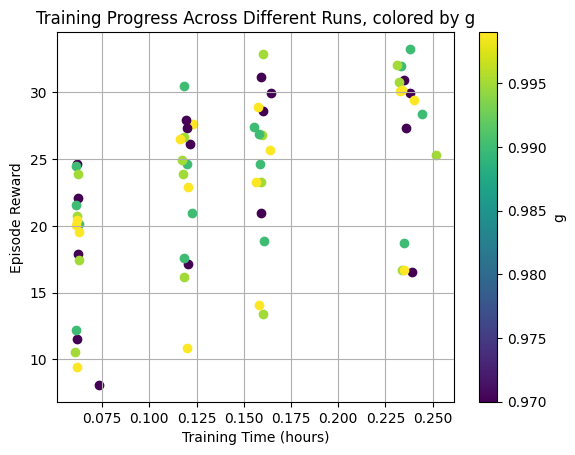

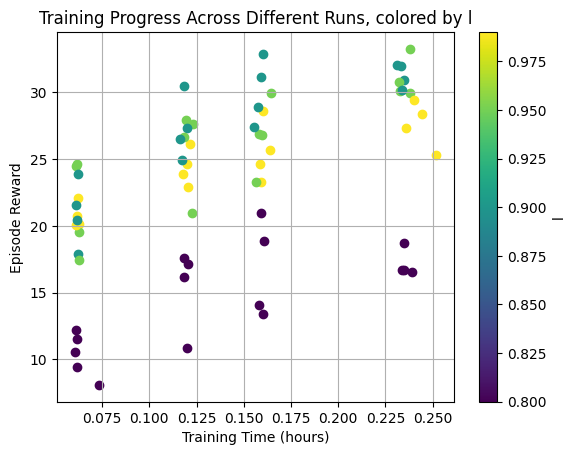

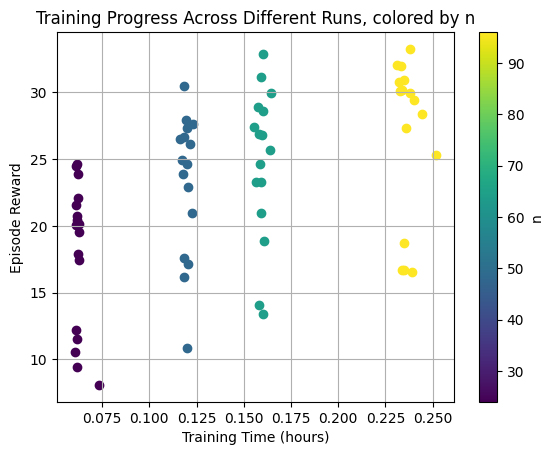

In [4]:
import re

def extract_values(run_name):
    pattern = r'CTE_g(.*)_l(.*)_n(.*)_(.*)_(.*)'
    match = re.match(pattern, run_name)
    if match:
        return match.groups()
    else:
        return None

for run in all_data:
    run_name = run['run'].iloc[0]
    values = extract_values(run_name)
    if values:
        g, l, n, date, time = values
        run['g'] = float(g)
        run['l'] = float(l)
        run['n'] = int(n)





for param in ['g', 'l', 'n']:
    param_values = [run[param][0] for run in all_data]
    cmin, cmax = min(param_values), max(param_values)

    plt.figure()
    for run in all_data:
        plt.scatter(max(run['rel_time']), max(run['rew_direction']), c=run[param][0], cmap='viridis', vmin=cmin, vmax=cmax)

    plt.colorbar(label=param)
    plt.xlabel('Training Time (hours)')
    plt.ylabel('Episode Reward')
    plt.title(f'Training Progress Across Different Runs, colored by {param}')
    plt.grid(True)

In [5]:
max_reward_run = max(all_data, key=lambda run: max(run['rew_direction']))
print(f"Run with maximum reward: {max_reward_run['run'].iloc[0]}")


Run with maximum reward: CTE_g0.99_l0.95_n96_2025-03-18_05-28-17
